In [1]:
# CSI5155 - ASSIGNEMENT 1 
# FALL 2022
# ADRIEN HEYMANS
# Pr. Herna L. Viktor, Phd

In [2]:
# Importing the data

import numpy as np
import pandas as pd

data = "data/drug_consumption.csv"

# Retrieving the data from the csv file
df = pd.read_csv(data)
df.columns = ["id","age","gender","education","country","ethnicity","nscore","escore","oscore","ascore","cscore","impulsive","ss","alcohol","amphet","amyl","benzos","caff","canabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh","lsd","meth","mushrooms","nicotine","semer","vsa"]

# We want to convert this problem to a binary classification C1,C2 = "non-user" and C3,C4,C5,C6 = "user"
df = df.replace(['CL0','CL1'],0)
df = df.replace(['CL2','CL3','CL4','CL5','CL6'],1)

# Saving the processed data in a separate file for visualization
df.to_csv("data/processed_data.csv",index=False)
print(df.shape)

(1884, 32)


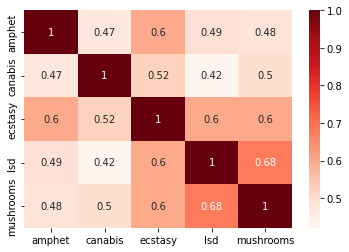

In [3]:
# Now that we have trasnformed this into a binary classification problem, we can start looking into the feature engineering of the dataset.
# We can see that we have two type of features : demographic and personnality. But before deciding which one we want to keep, we should first get a feel of the data. 

import pandas as pd
from sklearn import preprocessing
import numpy as np

# Removing the ID column as it is not relevant here
allData = df.drop(["id"],axis=1)
allData.to_csv("data/allData.csv",index=False)

# Normalization of the data 
allData_normalized=allData
cols_to_norm = ["nscore","escore","oscore","ascore","cscore","impulsive","ss","age","gender","education","country","ethnicity"]
allData_normalized[cols_to_norm] = allData_normalized[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
allData_normalized.to_csv("data/allData_normalized.csv")
allData=allData_normalized
allData.loc[(df!=0).any(axis=1)]


# Checking the correlationnbetween drugs
# Using Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns
drugData = allData.drop(["nscore","escore","oscore","ascore","cscore","impulsive","ss","age","gender","education","country","ethnicity","alcohol","amyl","benzos","coke","crack","heroin","ketamine","legalh","meth","nicotine","vsa","caff","choc","semer"],axis=1)
cor = drugData.corr()
cor.reindex(cor.mean().sort_values().index, axis=1)

# Printing the heat map
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [13]:
import array
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score,accuracy_score,recall_score, precision_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif,chi2
from mlxtend.feature_selection import ColumnSelector

# We have 19 diffrent drugs to classify, this means that we will need to do 19 different classification
all_drugs = ["alcohol","amphet","amyl","benzos","canabis","coke","crack","ecstasy","heroin","ketamine","legalh","lsd","meth","mushrooms","nicotine","vsa","caff","choc"]
selected_drugs = ["amphet","canabis","ecstasy","legalh","lsd","mushrooms"]

# Name of the folder to store the results
folder_name = ["tree_classifier","svm_classifier","random_forest_classifier","knn_classifier"]


# Table that keeps track of all the results for all models 
summary_results = pd.DataFrame(columns=["Drug","Recall","Precision","Balanced Accuracy","Selected Features"])

# Looping through the 4 models 
for folder in folder_name:

    print('\033[1m'+folder.upper()+'\033[0m')

    # Adding a row for this model in the summary result table
    new_row = {"Drug":folder.upper(),"Precision":"*","Recall":"*","Balanced Accuracy":"*","Selected Features":"*"}
    summary_results = summary_results.append(new_row,ignore_index=True)

    # Creating an array to store the results
    results = pd.DataFrame(columns=["Drug","Recall","Precision","Balanced Accuracy","Selected Features"])

    # Values to keep track of accuracy 
    overall_accuracy = 0
    overall_recall =0
    overall_precision=0

    # Looping through all the drugs and doing prediction for each of them seprately 
    for cl in selected_drugs:

        row = []

        # Feature selection, we are creating a testing and training set on all the features (demographic/persopnnality)
        X_train, X_test, y_train, y_test = train_test_split( allData.drop(all_drugs, axis=1),allData[cl], test_size=0.3,random_state=0)
        
        # Creating a model; based on logistic regression to select the most relevant features for this specific drug
        # select = SelectFromModel(estimator=LogisticRegression())
        # select.fit(X_train, y_train)
        
        # # Retrieving the relevant features
        # status = select.get_support()

        # Retrieving demographic and personnality data 
        features = list(allData.drop(all_drugs,axis=1).columns.values)

        # Creating a list of the selected features 
        # selected_features=[]
        # index = 0
        # for elem in features:
        #     if (status[index]==True):
        #         selected_features.append(elem)
        #     index=index+1

        # Creating the the testing and training for prediction 
       # X_train, X_test, y_train, y_test = train_test_split( allData,allData[cl], test_size=0.3,random_state=0)

        #Using the classifier
        if (folder=="tree_classifier"):
            clf1 = tree.DecisionTreeClassifier() 
        elif (folder=="knn_classifier"):
            clf1 = KNeighborsClassifier()
        elif (folder=="svm_classifier"):
            clf1= svm.SVC(probability=True)
        else:
            clf1 = RandomForestClassifier()


        # Using a pipeline for sclaing, feature selection and classification 
        pipe = Pipeline([('scaler', StandardScaler()),
                    ('selector', SelectKBest(chi2, k=5)),
                    ('classifier', clf1)])

        # Defininf the search space for this pipeline 
        if (folder=="tree_classifier"):
            search_space = [
                    {'classifier': [clf1]}]
        elif (folder=="knn_classifier"):
            search_space = [
                    {'classifier': [clf1],
                    'classifier__n_neighbors':[5,10,15,20,25,30,35,40,45,50]}]
        elif (folder=="svm_classifier"):
            search_space = [
                    {'classifier': [clf1]}]
        else:
            search_space = [
                    {'classifier': [clf1]}]
        
                

        # Using cross validation and pipelines 
        clf2 = GridSearchCV(pipe, list(search_space), cv=10, verbose=0)
        
        # Fitting the data 
        clf2.fit(X_train,y_train)
        y_pred = clf2.predict(X_test)

        # Displaying the best estimator
        best_pipeline = clf2.best_estimator_
        print("Best features for "+cl+" : "+str(list(best_pipeline.feature_names_in_)))
    
        # Saving the classification report of the drug
        class_report = classification_report(y_test, y_pred,output_dict=True)
        class_report_data = pd.DataFrame(class_report).transpose()
        class_report_data.to_csv("results/"+folder+"/classification_report/"+cl+"_classification_report.csv")

        # Saving the confusion matrix of the drug
        color = 'black'
        matrix = plot_confusion_matrix(clf2, X_test, y_test, cmap=plt.cm.Reds)
        matrix.ax_.set_title('Confusion Matrix', color=color)
        plt.xlabel('Predicted Label', color=color)
        plt.ylabel('True Label', color=color)
        plt.gcf().axes[0].tick_params(colors=color)
        plt.gcf().axes[1].tick_params(colors=color)
        plt.savefig("results/"+folder+"/confusion_matrix/"+cl+"_confusion_matrix.png")
        plt.clf()

        # Computing the results
        print("Accuracy for "+cl+" : "+str(balanced_accuracy_score(y_test, y_pred)))
        overall_accuracy = overall_accuracy + balanced_accuracy_score(y_test, y_pred)
        overall_recall = overall_recall + recall_score(y_test, y_pred)
        overall_precision = overall_precision + precision_score(y_test, y_pred)
        
        # Create the ROC
        y_pred_proba = clf2.predict_proba(X_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        plt.clf()
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1],'r--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.savefig("results/"+folder+"/ROC/"+cl+"_roc.png")

        # Adding the accuracy results to the result array
        new_row = {"Drug":cl,"Precision":precision_score(y_test, y_pred, average='weighted'),"Recall":recall_score(y_test, y_pred, average='weighted'),"Balanced Accuracy":balanced_accuracy_score(y_test, y_pred),"Selected Features":str(list(best_pipeline.feature_names_in_))}
        results = results.append(new_row,ignore_index=True)
        summary_results = summary_results.append(new_row,ignore_index=True)

    # Adding a row to the result table for overall results of all the drugs using the model
    new_row = {"Drug":"All drugs","Recall":overall_recall/len(selected_drugs),"Precision":overall_precision/len(selected_drugs),"Balanced Accuracy":overall_accuracy/len(selected_drugs)}
    results = results.append(new_row,ignore_index=True) 

    # Saving the results to a .csv file
    results.to_csv("results/"+folder+"/"+folder+"_results.csv")

    # Printing overall Accuracy 
    print("Overall Accuracy : "+str(overall_accuracy/len(selected_drugs)))

# Saving the summary result as a csv file
summary_results.to_csv("results/summary_results.csv")


TREE_CLASSIFIER


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/p

ValueError: Input X must be non-negative.

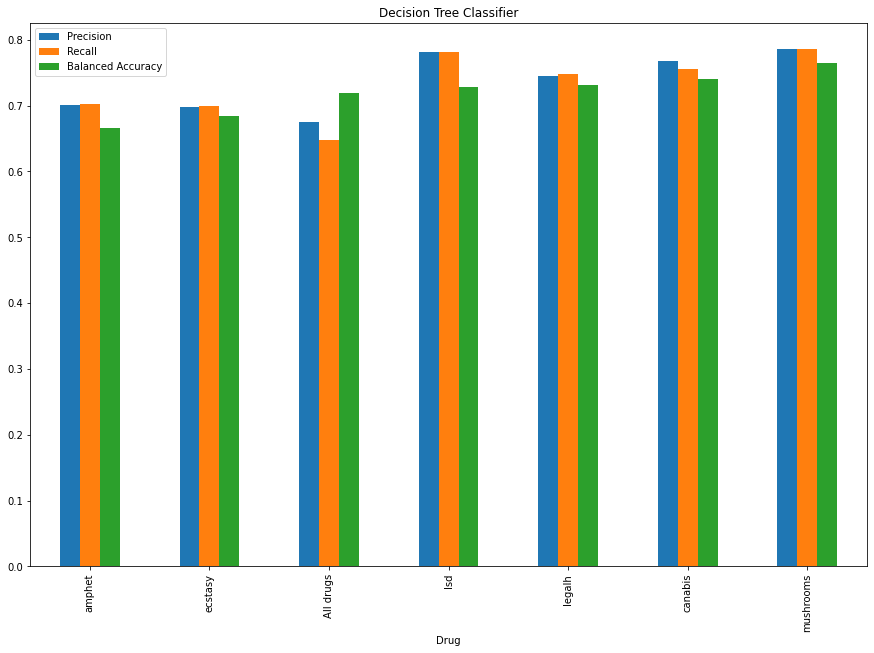

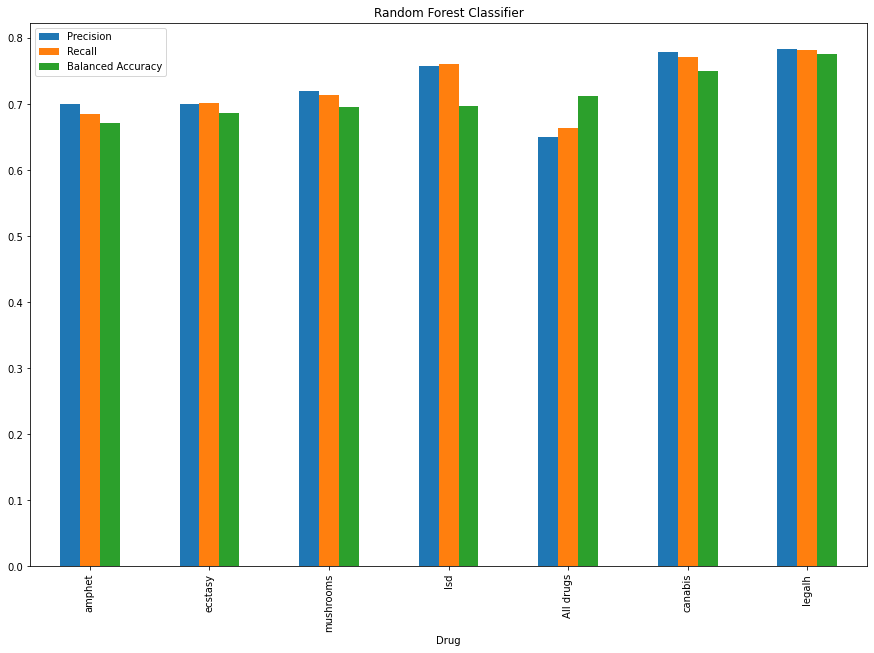

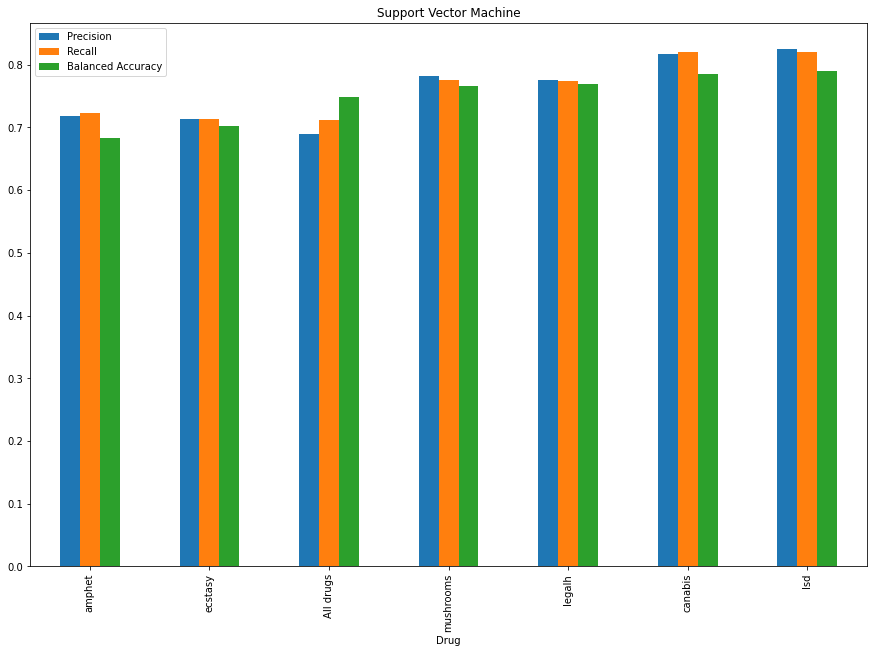

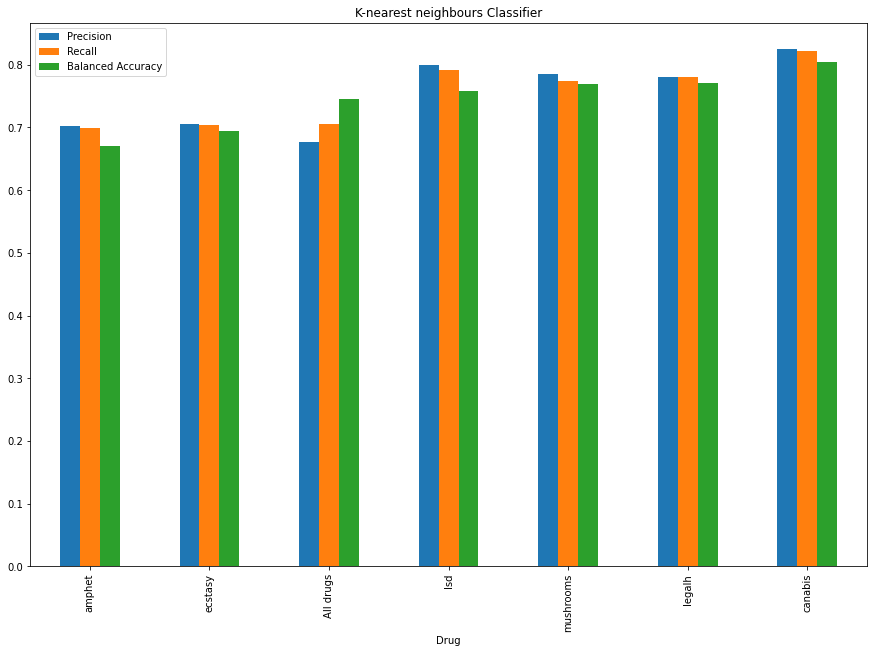

In [5]:
# We want to plot the results to visualise them 

# Decision tree 
tree_results = pd.read_csv("results/tree_classifier/tree_classifier_results.csv")
tree_results = tree_results[tree_results["Balanced Accuracy"] > 0].sort_values("Balanced Accuracy")
fig1 =tree_results.plot(x="Drug",y=["Precision","Recall","Balanced Accuracy"],kind="bar",title="Decision Tree Classifier",figsize=(15,10))
fig1.set_facecolor('xkcd:white')
pic = fig1.get_figure()

pic.savefig("results/tree_classifier/tree_results.png")
# Random Forest
random_forest_results = pd.read_csv("results/random_forest_classifier/random_forest_classifier_results.csv")
random_forest_results = random_forest_results[random_forest_results["Balanced Accuracy"] > 0].sort_values("Balanced Accuracy")
fig2 = random_forest_results.plot(x="Drug",y=["Precision","Recall","Balanced Accuracy"],kind="bar",title="Random Forest Classifier",figsize=(15,10))
pic = fig2.get_figure()
pic.savefig("results/random_forest_classifier/random_forest_results.png")

# SVM
svm_results = pd.read_csv("results/svm_classifier/svm_classifier_results.csv")
svm_results = svm_results[svm_results["Balanced Accuracy"] > 0].sort_values("Balanced Accuracy")
fig3 = svm_results.plot(x="Drug",y=["Precision","Recall","Balanced Accuracy"],kind="bar",title="Support Vector Machine",figsize=(15,10))
pic = fig3.get_figure()
pic.savefig("results/svm_classifier/svm_results.png")
# KNN
knn_results = pd.read_csv("results/knn_classifier/knn_classifier_results.csv")
knn_results = knn_results[knn_results["Balanced Accuracy"] > 0].sort_values("Balanced Accuracy")
fig4 = knn_results.plot(x="Drug",y=["Precision","Recall","Balanced Accuracy"],kind="bar",title="K-nearest neighbours Classifier",figsize=(15,10))
pic = fig4.get_figure()
pic.savefig("results/knn_classifier/knn_results.png")